##1 Installing Required Libraries
This step ensures that all necessary Python packages are available for the notebook.

gensim → Provides tools for topic modeling, word embeddings, and other natural language processing (NLP) tasks.

pandas → A versatile data manipulation library for handling datasets in tabular form.

scikit-learn → Offers a wide range of machine learning algorithms, along with utilities for preprocessing, model selection, and evaluation.

In [1]:
!pip install gensim pandas   scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 14.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.1
    Uninstalling scipy-1.16.1:
      Successfully uninstalled scipy-1.16.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatib

In [1]:
import pandas as pd
import numpy as np
import json
import ast # To safely evaluate string representation of list
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack

import pandas as pd
from sklearn.feature_extraction import DictVectorizer
import torch


from gensim.models import Word2Vec
from google.colab import drive

In [ ]:
# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda




## 2. Fixing Broken CSV Rows with Unbalanced Quotes

In this step:

The script reads the raw CSV (order_data.csv) line-by-line, buffering text until it detects a balanced number of quotes (") in the current chunk.

If the number of quotes is even, it means the row is complete and safe to write to the cleaned file.

If quotes are still unbalanced (odd count), the script keeps appending subsequent lines until the row is closed properly.

The result is a new, cleaned CSV (order_data_cleaned.csv) where each row is structurally intact—preventing parsing issues in pandas or other tools downstream.

In [6]:
import os

input_file = '/content/drive/MyDrive/Colab Notebooks/WWT Hackathon/content/Dataset/order_data.csv'
output_file = '/content/drive/MyDrive/Colab Notebooks/WWT Hackathon/content/Dataset/order_data_cleaned.csv'

# Check if the input file exists
if not os.path.exists(input_file):
    print(f"Error: Input file not found at {input_file}")
else:
    with open(input_file, 'r', encoding='utf-8', errors='ignore') as infile, \
         open(output_file, 'w', encoding='utf-8') as outfile:

        quote_open = False
        buffer = ''

        for line in infile:
            buffer += line

            # Count quotes in the buffer to see if it's complete
            quote_count = buffer.count('"')

            if quote_count % 2 == 0:
                outfile.write(buffer)
                buffer = ''  # reset buffer
            else:
                buffer += '\n'  # continue reading to complete the line

    print("✅ Cleaned file saved to:", output_file)

✅ Cleaned file saved to: /content/drive/MyDrive/Colab Notebooks/WWT Hackathon/content/Dataset/order_data_cleaned.csv


## 3. Data Loading and Preparation

This section reuses the robust data cleaning pipeline from our EDA to create the Analytical Base Table (ABT). We then encode all categorical features into unique numerical IDs, which are required for the model's embedding layers.

In [7]:

# 1) Mount Google Drive
drive.mount('/content/drive')
# --- 1. Load Data ---
file_path = '/content/drive/MyDrive/Colab Notebooks/WWT Hackathon/content/Dataset/'
order_data = pd.read_csv(file_path + 'order_data_cleaned.csv', on_bad_lines='skip')
customer_data = pd.read_csv(file_path + 'customer_data.csv')
store_data = pd.read_csv(file_path +'store_data_full.csv')
test_question_data = pd.read_csv(file_path + 'test_data_question.csv')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 4. Combining Orders with Store and Customer Information

Raw order records by themselves often lack the full context needed for analysis. Here, we progressively merge datasets to create a unified view:  

1. **Orders ↔ Store Data** (`STORE_NUMBER` as key)  
   - Enriches each order with store-level attributes such as location, region, or store type.  
   - `how='left'` ensures that all orders are retained, even if some store details are missing.  

2. **(Orders + Store) ↔ Customer Data** (`CUSTOMER_ID` as key)  
   - Adds demographic or behavioral attributes for each customer, enabling more nuanced analysis.  
   - Again, a left join is used so that every order from the first merge remains in the dataset.  

The resulting `final_merged_data` becomes the **master dataset**—a single, feature-rich table that will drive the rest of the preprocessing, feature engineering, and modeling steps.


In [8]:
# Merge order_data with store_data on 'STORE_NUMBER'
merged_data = pd.merge(order_data, store_data, on='STORE_NUMBER', how='left')

# Merge the result with customer_data on 'CUSTOMER_ID'
final_merged_data = pd.merge(merged_data, customer_data, on='CUSTOMER_ID', how='left')
final_merged_data.head()
print(final_merged_data.shape)



(1048575, 10)


In [9]:
# Load the merged dataset
df = final_merged_data
# Remove rows with any null values
cleaned_df = df.dropna()
# Assuming your cleaned DataFrame is named cleaned_df
shape = cleaned_df.shape
print(shape)

(1012935, 10)


##6. Extracting Relevant Food Items from Order Data

Order records often include both actual menu items and system-generated entries (e.g., fees, tips, delivery charges).  
This step focuses on **isolating true food items** by:  

- Defining a list of `system_keywords` that mark non-food entries to exclude.  
- Parsing the JSON structure in the `ORDERS` column to locate `item_details`.  
- Skipping:
  - Items with `item_price = 0` (free or placeholder entries).  
  - Items whose names contain any of the system keywords (case-insensitive match).  
- Returning a clean list of only the purchased food item names for each order.  

The function `extract_food_items()` is applied to every row in the dataset to populate a new `extracted_items` column, which will be useful for later steps like:
- Menu trend analysis  
- Recommendation systems  
- Word embedding training for food item names  


In [10]:
# Define the keywords to be excluded
system_keywords = [
    'tip', 'fee', 'bag', 'delivery', 'service', 'charge',
    'memo', 'blankline', 'asap', 'paid', 'subtotal', 'tax'
]

def extract_food_items(orders_json_string):
    """
    Parses the JSON string from the 'ORDERS' column, filters out non-food items,
    and returns a list of food item names.
    """
    if not isinstance(orders_json_string, str):
        return []

    try:
        data = json.loads(orders_json_string)
        if 'orders' not in data or not data['orders'] or 'item_details' not in data['orders'][0]:
             return []

        item_details = data['orders'][0]['item_details']
        food_items = []

        for item in item_details:
            if item.get('item_price', 0) == 0:
                continue

            item_name_lower = item.get('item_name', '').lower()
            if any(keyword in item_name_lower for keyword in system_keywords):
                continue

            food_items.append(item['item_name'])

        return food_items

    except (json.JSONDecodeError, TypeError, KeyError):
        return []

# Load the previously cleaned data

df = cleaned_df # Modified line

# Apply the function to create the new 'extracted_items' column
df['extracted_items'] = df['ORDERS'].apply(extract_food_items)

# Save the result to a new CSV file
# df.to_csv('final_data_with_items.csv', index=False)

# Display the relevant columns of the resulting DataFrame
print(df.head())

   CUSTOMER_ID  STORE_NUMBER ORDER_CREATED_DATE    ORDER_ID  \
0    362204699          2156         24-07-2024  7247194287   
1    269612955          1419         15-02-2025   791214421   
2    585330633          2249         15-02-2025  7575285208   
3    950661333          2513         29-03-2024  4253875716   
4    434985772          1754         08-04-2024  7150407872   

                                              ORDERS ORDER_CHANNEL_NAME  \
0  {"orders": [{"item_details": [{"item_name": "O...            Digital   
1  {"orders": [{"item_details": [{"item_name": "R...            Digital   
2  {"orders": [{"item_details": [{"item_name": "2...            Digital   
3  {"orders": [{"item_details": [{"item_name": "O...            Digital   
4  {"orders": [{"item_details": [{"item_name": "O...            Digital   

  ORDER_SUBCHANNEL_NAME ORDER_OCCASION_NAME      CITY_FILLED CUSTOMER_TYPE  \
0                   WWT                ToGo        GRAPEVINE    Registered   
1             

/tmp/ipython-input-454583920.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['extracted_items'] = df['ORDERS'].apply(extract_food_items)


In [11]:
# # Load the dataset
# df = pd.read_csv('final_data_with_items.csv')

print("Columns before removal:")
print(df.columns)

# Remove the 'ORDERS' column
df_no_orders = df.drop('ORDERS', axis=1)

print("\nColumns after removal:")
print(df_no_orders.columns)


print(df_no_orders )
df_no_orders.to_csv('final_data.csv', index=False)

Columns before removal:
Index(['CUSTOMER_ID', 'STORE_NUMBER', 'ORDER_CREATED_DATE', 'ORDER_ID',
       'ORDERS', 'ORDER_CHANNEL_NAME', 'ORDER_SUBCHANNEL_NAME',
       'ORDER_OCCASION_NAME', 'CITY_FILLED', 'CUSTOMER_TYPE',
       'extracted_items'],
      dtype='object')

Columns after removal:
Index(['CUSTOMER_ID', 'STORE_NUMBER', 'ORDER_CREATED_DATE', 'ORDER_ID',
       'ORDER_CHANNEL_NAME', 'ORDER_SUBCHANNEL_NAME', 'ORDER_OCCASION_NAME',
       'CITY_FILLED', 'CUSTOMER_TYPE', 'extracted_items'],
      dtype='object')
         CUSTOMER_ID  STORE_NUMBER ORDER_CREATED_DATE    ORDER_ID  \
0          362204699          2156         24-07-2024  7247194287   
1          269612955          1419         15-02-2025   791214421   
2          585330633          2249         15-02-2025  7575285208   
3          950661333          2513         29-03-2024  4253875716   
4          434985772          1754         08-04-2024  7150407872   
...              ...           ...                ...        

In [12]:
# Load the cleaned data
df = pd.read_csv('final_data.csv')

##7. Analyzing Item Counts and Menu Diversity

After extracting clean food item names, this step performs **basic descriptive statistics** to understand order size patterns and menu variety:  

1. **Convert String to List**  
   - The `extracted_items` column (currently stored as a string) is converted back into an actual Python list using `ast.literal_eval` for safe evaluation.  

2. **Order Size Statistics**  
   - `item_count`: Number of items in each order.  
   - `max_items`, `min_items`, `median_items`: Key metrics showing the largest, smallest, and median order sizes.  
   - These figures can help identify extreme orders, typical purchasing patterns, and operational considerations for fulfillment.  

3. **Menu Diversity**  
   - Combines all extracted item lists into one flat list (`all_items`).  
   - Calculates `num_unique_items` by converting to a `set`, revealing how many distinct food items are present across all orders.  
   - Useful for understanding menu breadth, designing recommendation systems, and guiding stock/inventory planning.  


In [13]:
# Convert the string representation of a list back into a list object
df['extracted_items_list'] = df['extracted_items'].apply(ast.literal_eval)

# --- 1, 2, 3: Calculate Max, Min, and Median number of items ---

# Get the number of items in each order
df['item_count'] = df['extracted_items_list'].apply(len)

# Calculate the stats
max_items = df['item_count'].max()
min_items = df['item_count'].min()
median_items = df['item_count'].median()

print(f"Maximum number of items in a single order: {max_items}")
print(f"Minimum number of items in a single order: {min_items}")
print(f"Median number of items per order: {median_items}")


# --- 4: Calculate the number of unique items ---

# Create a single list of all items from all orders
all_items = [item for sublist in df['extracted_items_list'] for item in sublist]

# Find the unique items using a set
num_unique_items = len(set(all_items))

print(f"Total number of unique items across all orders: {num_unique_items}")

Maximum number of items in a single order: 15
Minimum number of items in a single order: 0
Median number of items per order: 2.0
Total number of unique items across all orders: 128


## 8. Filtering Out Small or Empty Orders

Not all orders are equally useful for downstream analysis.  
This step removes orders that contain too few items to provide meaningful insights:  

1. **Item Count Calculation**  
   - Recomputes `item_count` as the length of each `extracted_items_list`.  

2. **Filtering Criteria**  
   - Keeps only rows where `item_count > 1`.  
   - This excludes:
     - Empty orders (possible data errors)  
     - Single-item orders (less informative for co-occurrence or recommendation modeling).  

3. **Result**  
   - `df_filtered` becomes the refined dataset, containing only orders with a richer set of items, making it more suitable for analyses such as:
     - Association rule mining  
     - Basket analysis  
     - Menu combination patterns  


In [14]:
# First, create a column that holds the number of items in each list.
df['item_count'] = df['extracted_items_list'].apply(len)

# Now, filter the DataFrame, keeping only rows where 'item_count' is not 0.
df_filtered = df[df['item_count'] > 1].copy()

# 'df_filtered' now contains only the entries with one or more items.
# You can display it by uncommenting the line below:
print(df_filtered )
print(df_filtered.shape )

         CUSTOMER_ID  STORE_NUMBER ORDER_CREATED_DATE    ORDER_ID  \
0          362204699          2156         24-07-2024  7247194287   
1          269612955          1419         15-02-2025   791214421   
3          950661333          2513         29-03-2024  4253875716   
4          434985772          1754         08-04-2024  7150407872   
6          426992703          2156         15-02-2025  1655782790   
...              ...           ...                ...         ...   
1012930    991507396          4094         24-02-2025   278450715   
1012931    991507396          4094         22-01-2025  5021306418   
1012932    991507396          4094         25-03-2025  4131451329   
1012933    991507396          4094         25-08-2024  8875040363   
1012934    729600859          4595         29-10-2024  3480530584   

        ORDER_CHANNEL_NAME ORDER_SUBCHANNEL_NAME ORDER_OCCASION_NAME  \
0                  Digital                   WWT                ToGo   
1                  Digital 

## 9. Identifying Repeat Customers  

Understanding repeat customer behavior is important for loyalty analysis and targeted marketing.  
This step identifies customers who appear in the dataset more than once:  

1. **Frequency Count**  
   - Uses `value_counts()` on the `CUSTOMER_ID` column to determine how many orders each customer has placed.  

2. **Filtering for Repeat Customers**  
   - Keeps only entries where the count is greater than 1.  

3. **Output**  
   - Displays a list of `CUSTOMER_ID`s and their corresponding order counts if repeats exist.  
   - If no repeat customers are found, it prints a clear message instead.  


In [15]:
df = df_filtered


# Get the frequency count of each CUSTOMER_ID
customer_frequency = df['CUSTOMER_ID'].value_counts()

# Filter to find only the customers who have appeared more than once
repeated_customers = customer_frequency[customer_frequency > 1]

# Display the result
if repeated_customers.empty:
    print("No repeated customer IDs found in the data.")
else:
    print("Frequency of Repeated Customer IDs:")
    print(repeated_customers)

Frequency of Repeated Customer IDs:
CUSTOMER_ID
522408835    1273
575231786     150
807861401     107
963730416      86
755237459      84
             ... 
190416050       2
58477150        2
339995743       2
290442816       2
111140082       2
Name: count, Length: 87447, dtype: int64


## 10. Visualizing Repeat Customer Order Frequency

After identifying repeat customers, this step examines how frequently they place orders within a reasonable range:  

1. **Filtering Frequency Range**  
   - Keeps only customers with **1–150 orders**.  
   - This removes extreme outliers that could distort the visualization (e.g., system test accounts or bulk buyers).  

2. **Distribution Plot**  
   - Uses `seaborn.histplot` to show how many customers fall into each order-count bucket.  
   - **X-axis:** Number of orders per customer.  
   - **Y-axis:** Number of customers with that order count.  

3. **Purpose**  
   - Helps understand purchasing behavior patterns.  
   - Can guide loyalty program thresholds, targeted campaigns, and operational forecasting.  


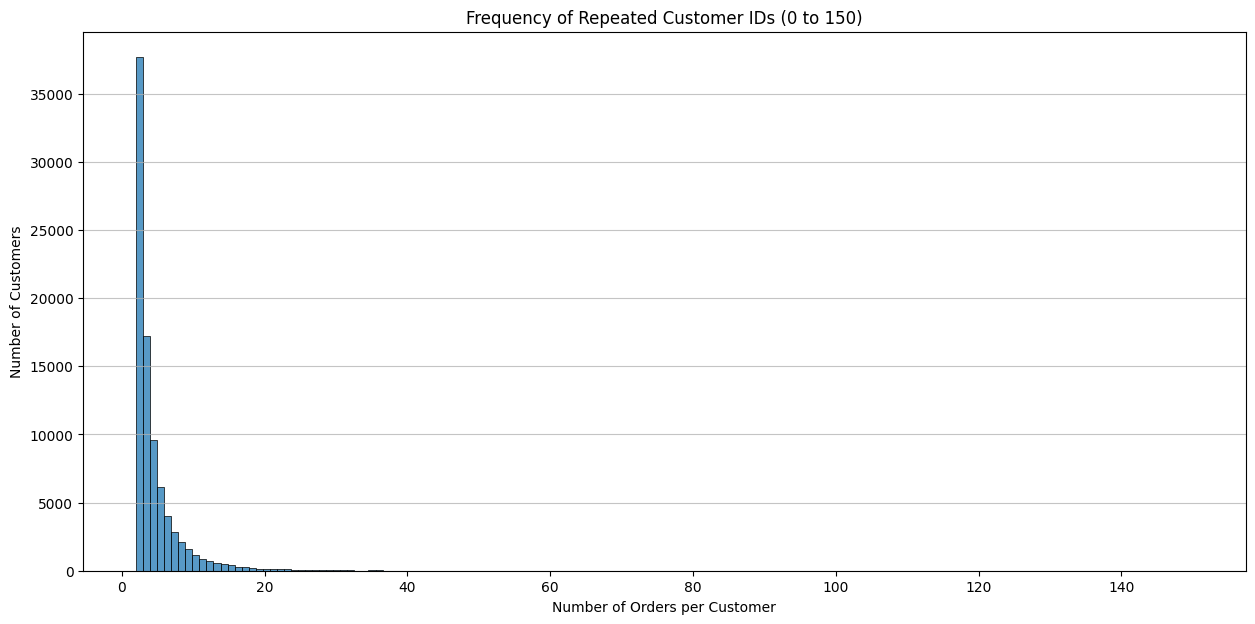

In [16]:
# Filter the repeated_customers Series for frequencies between 0 and 150
repeated_customers_filtered = repeated_customers[(repeated_customers > 0) & (repeated_customers <= 150)]

# Create a bar plot
plt.figure(figsize=(15, 7))
sns.histplot(repeated_customers_filtered, bins=150, kde=False) # Using histplot to show distribution of frequencies
plt.title('Frequency of Repeated Customer IDs (0 to 150)')
plt.xlabel('Number of Orders per Customer')
plt.ylabel('Number of Customers')
plt.grid(axis='y', alpha=0.75)
plt.show()

## 11. Splitting Customers by Purchase Frequency  

To better segment the customer base, this step separates customers into two distinct groups based on their order frequency:  

1. **Count Orders per Customer**  
   - Uses `value_counts()` to compute how many orders each `CUSTOMER_ID` has placed.  

2. **Define High-Frequency Customers**  
   - Customers with **more than 2 orders** are classified as repeat-heavy customers.  

3. **DataFrame Segmentation**  
   - **`df_repeated_more_than_2`** → Orders from high-frequency customers (> 2 orders).  
   - **`df_others`** → Orders from all remaining customers (1–2 orders).  

4. **Purpose**  
   - Enables targeted analysis and personalized marketing.  
   - High-frequency customers can be prioritized for retention strategies, while others may be targeted for re-engagement campaigns.  


In [17]:
# 1. Get the frequency count of each CUSTOMER_ID
customer_frequency = df['CUSTOMER_ID'].value_counts()

# 2. Identify the IDs of customers who appear more than twice
frequent_customer_ids = customer_frequency[customer_frequency > 2].index

# 3. Create the first DataFrame with customers appearing > 2 times
df_repeated_more_than_2 = df[df['CUSTOMER_ID'].isin(frequent_customer_ids)].copy()

# 4. Create the second DataFrame with all other customers (appearing 1 or 2 times)
df_others = df[~df['CUSTOMER_ID'].isin(frequent_customer_ids)].copy()


# --- Display the results ---

print("--- DataFrame 1: Customers Repeated More Than 2 Times ---")
if df_repeated_more_than_2.empty:
    print("No customers found who appeared more than 2 times.")
else:
    print(df_repeated_more_than_2)

print("\n" + "="*55 + "\n") # Separator

print("--- DataFrame 2: Other Customers (Appeared 1 or 2 Times) ---")
if df_others.empty:
    print("No other customers found.")
else:
    print(df_others)


--- DataFrame 1: Customers Repeated More Than 2 Times ---
         CUSTOMER_ID  STORE_NUMBER ORDER_CREATED_DATE    ORDER_ID  \
321441       5390549          4391         24-02-2025  6442283098   
321442       5390549          4391         31-07-2024   804028356   
321444       5390549          4391         25-04-2025  5755222216   
321445       5390549          4391         08-01-2025  9601434771   
321446       5390549          4391         18-04-2024  1229377604   
...              ...           ...                ...         ...   
1012928    991507396          4094         08-01-2025  8381642281   
1012930    991507396          4094         24-02-2025   278450715   
1012931    991507396          4094         22-01-2025  5021306418   
1012932    991507396          4094         25-03-2025  4131451329   
1012933    991507396          4094         25-08-2024  8875040363   

        ORDER_CHANNEL_NAME ORDER_SUBCHANNEL_NAME ORDER_OCCASION_NAME  \
321441             Digital               

In [18]:
# Data Preparation for WordtoVec
# print(df_filtered )

df_wordtovec = df_filtered[['CUSTOMER_ID', 'extracted_items_list']]
print(df_wordtovec )
df_wordtovec.head()

         CUSTOMER_ID                               extracted_items_list
0          362204699  [10 pc Grilled Wings Combo, 8 pc Grilled Wings...
1          269612955  [Ranch Dip - Regular, 50 pc Grilled Wings, Reg...
3          950661333         [20 pc Grilled Wings, Ranch Dip - Regular]
4          434985772  [6 pc Grilled Wings Combo, 8 pc Grilled Wings ...
6          426992703         [10 pc Grilled Wings, Ranch Dip - Regular]
...              ...                                                ...
1012930    991507396  [Regular Buffalo Fries, Veggie Sticks Spicy, R...
1012931    991507396  [Ranch Dip - Regular, Fried Corn - Regular, Ve...
1012932    991507396       [20pc Spicy Feast Deal, Ranch Dip - Regular]
1012933    991507396  [6 pc Spicy Wings Combo, 6 pc Grilled Wings Co...
1012934    729600859  [6 pc Spicy Wings Combo, 10 pc Spicy Wings Combo]

[578791 rows x 2 columns]


,CUSTOMER_ID,extracted_items_list
0,362204699,"[10 pc Grilled Wings Combo, 8 pc Grilled Wings..."
1,269612955,"[Ranch Dip - Regular, 50 pc Grilled Wings, Reg..."
3,950661333,"[20 pc Grilled Wings, Ranch Dip - Regular]"
4,434985772,"[6 pc Grilled Wings Combo, 8 pc Grilled Wings ..."
6,426992703,"[10 pc Grilled Wings, Ranch Dip - Regular]"


## 12. Preparing Order Data for Word2Vec Training  

Before building a Word2Vec model to learn vector representations of food items, the order data needs to be structured into training sequences:  

1. **Extract Item Lists**  
   - Takes the `extracted_items_list` column from `df_wordtovec` and converts it into a list of lists (`all_orders`), where each sublist represents the items in a single order.  

2. **Training Sentences**  
   - Assigns `all_orders` directly to `training_sentences`, which will be the input format expected by the Word2Vec algorithm.  
   - Each "sentence" corresponds to a basket of items, allowing the model to learn co-occurrence relationships.  

3. **Purpose**  
   - Sets up the dataset so Word2Vec can capture similarities and associations between items, enabling applications like product recommendations or menu clustering.  


In [19]:
# Extract the lists of items from the DataFrame column.
all_orders = df_wordtovec['extracted_items_list'].tolist()

# Create training_sentences from all_orders
training_sentences = all_orders # Added this line

print(f"Started with {len(all_orders)} orders.")
print(f"Training model on {len(training_sentences)} orders with more than one item. ✅")

Started with 578791 orders.
Training model on 578791 orders with more than one item. ✅


## 13. Training the Item2Vec Model  

With the order data structured as lists of items, we now train a Word2Vec model—adapted here as **Item2Vec**—to learn vector embeddings for each menu item:  

1. **Model Parameters**  
   - **`vector_size=40`** → Embedding dimension for each item vector.  
   - **`window=5`** → Context window size; items within 5 positions in an order are considered related.  
   - **`min_count=2`** → Ignores items that appear fewer than 2 times to reduce noise.  
   - **`workers=4`** → Uses 4 CPU threads for faster training.  

2. **Training Logic**  
   - Treats each order as a "sentence" and each item as a "word".  
   - Learns item embeddings based on co-occurrence patterns in orders.  

3. **Purpose**  
   - Captures semantic similarity between items (e.g., fries and burger vectors may be close).  
   - Can power recommendation systems, menu clustering, or basket analysis.  

4. **Persistence**  
   - Saves the trained model to `item2vec_model.bin` for reuse without retraining.  


In [20]:
## Step 2: Train the Item2Vec Model

# This creates and trains your model.
# - vector_size: The number of dimensions for the item vector.
# - window: The max distance between the current and predicted item in an order.
# - min_count: Ignores items with a total frequency lower than this.
# - workers: Number of CPU threads to use for training.
item2vec_model = Word2Vec(
    sentences=training_sentences,
    vector_size=40,
    window=5,
    min_count=2,
    workers=4
)

print("\nItem2Vec model trained successfully. 🚀")

# Optional: Save the model to disk for later use
item2vec_model.save("item2vec_model.bin")


Item2Vec model trained successfully. 🚀


In [21]:
## Step 3: How to Use the Trained Model

# You can now use the model to find items similar to a given item.
# This is perfect for your cold-start recommendation logic.

try:
    # Let's find items most similar to '32 Oz Soda'
    target_item = '32 Oz Soda'
    similar_items = item2vec_model.wv.most_similar(target_item, topn=3)

    print(f"\nItems most similar to '{target_item}':")
    for item, score in similar_items:
        print(f"  - Item: {item}, Similarity Score: {score:.4f}")

except KeyError:
    print(f"\nItem '{target_item}' not in the model's vocabulary.")


Items most similar to '32 Oz Soda':
  - Item: 20 Oz Soda, Similarity Score: 0.5229
  - Item: 30 pc Spicy Wings, Similarity Score: 0.4641
  - Item: 30 pc Grilled Wings, Similarity Score: 0.4543


In [22]:
from gensim.models import Word2Vec
full = Word2Vec.load("item2vec_model.bin")   # load your saved full model
full.wv.save("item2vec.kv")                  # save only the keyed vectors for inference


# **FM Data Prparation**

In [23]:
all_data = pd.read_csv('final_data.csv')
all_data.head()
# all_Data.shape


,CUSTOMER_ID,STORE_NUMBER,ORDER_CREATED_DATE,ORDER_ID,ORDER_CHANNEL_NAME,ORDER_SUBCHANNEL_NAME,ORDER_OCCASION_NAME,CITY_FILLED,CUSTOMER_TYPE,extracted_items
0,362204699,2156,24-07-2024,7247194287,Digital,WWT,ToGo,GRAPEVINE,Registered,"['10 pc Grilled Wings Combo', '8 pc Grilled Wi..."
1,269612955,1419,15-02-2025,791214421,Digital,WWT,ToGo,HUNTERSVILLE,Registered,"['Ranch Dip - Regular', '50 pc Grilled Wings',..."
2,585330633,2249,15-02-2025,7575285208,Digital,WWT,ToGo,"Winter Park, FL",Guest,['20pc Spicy Feast Deal']
3,950661333,2513,29-03-2024,4253875716,Digital,WWT,ToGo,LAS VEGAS,Registered,"['20 pc Grilled Wings', 'Ranch Dip - Regular']"
4,434985772,1754,08-04-2024,7150407872,Digital,WWT,ToGo,ARDMORE,Guest,"['6 pc Grilled Wings Combo', '8 pc Grilled Win..."


## 14. Preparing Data for the Factorization Machines (FM) Model  

This step reshapes and filters the dataset to create a clean, **customer-item-feature table** suitable for FM-based recommendation modeling:  

1. **Convert to Lists**  
   - Turns the `extracted_items` string representation into an actual Python list (`extracted_items_list`) for easier manipulation.  

2. **Focus on Frequent Customers**  
   - Identifies customers with **more than 2 orders** and keeps only their transactions (`df_frequent_customers`).  
   - This ensures the FM model has enough interaction data per customer to learn meaningful patterns.  

3. **Reshape to Long Format**  
   - Uses `explode()` so each item in an order becomes its own row, producing a **transaction-level dataset**.  

4. **Clarify Column Names**  
   - Renames the exploded item column to `item_name` for better readability.  

5. **Select Final Features**  
   - Keeps only relevant columns: customer ID, store info, order channels, customer type, and item name.  

6. **Handle Missing Values**  
   - Replaces any missing entries with `'unknown'` to avoid issues in downstream encoding or modeling.  

**Purpose:**  
The resulting `fm_data` DataFrame is in a **sparse-friendly format**, ideal for FM models to capture interactions between customers, items, and contextual order features.  


In [24]:
# Step 2: Convert the 'extracted_items' string into a real list
all_data['extracted_items_list'] = all_data['extracted_items'].apply(ast.literal_eval)

# Step 3: Find customers who have appeared more than twice
customer_counts = all_data['CUSTOMER_ID'].value_counts()
frequent_customer_ids = customer_counts[customer_counts > 2].index

# Step 4: Filter the DataFrame to keep only these frequent customers
df_frequent_customers = all_data[all_data['CUSTOMER_ID'].isin(frequent_customer_ids)].copy()

# Step 5: Transform the data into the "long" format
df_long = df_frequent_customers.explode('extracted_items_list')

# Step 6: Rename the new item column for clarity
df_long.rename(columns={'extracted_items_list': 'item_name'}, inplace=True)

# Step 7: Select only the final features you need
final_features = [
    'CUSTOMER_ID',
    'STORE_NUMBER',
    'ORDER_CHANNEL_NAME',
    'ORDER_SUBCHANNEL_NAME',
    'ORDER_OCCASION_NAME',
    'CUSTOMER_TYPE',
    'item_name'
]
fm_data = df_long[final_features]

# --- Display the final result ---
print("Data prepared for FM model (only customers with > 2 purchases):")
print(fm_data)

# --- FIX: Fill any potential missing values ---
fm_data.fillna('unknown', inplace=True)

print("Data loaded and cleaned successfully.")

Data prepared for FM model (only customers with > 2 purchases):
         CUSTOMER_ID  STORE_NUMBER ORDER_CHANNEL_NAME ORDER_SUBCHANNEL_NAME  \
321436     734312814           857            Digital                   WWT   
321437     734312814           857            Digital                   WWT   
321437     734312814           857            Digital                   WWT   
321438     734312814           857            Digital                   WWT   
321439     734312814           857            Digital                   WWT   
...              ...           ...                ...                   ...   
1012931    991507396          4094            Digital                   WWT   
1012932    991507396          4094            Digital                   WWT   
1012932    991507396          4094            Digital                   WWT   
1012933    991507396          4094            Digital                   WWT   
1012933    991507396          4094            Digital              

/tmp/ipython-input-2092737432.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fm_data.fillna('unknown', inplace=True)


In [25]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import os
import ast

print("Libraries imported successfully.")

Libraries imported successfully.


## 15. Defining the Upgraded PyTorch Factorization Machine Model & Helper Functions  

This cell builds the **PyTorch-based Factorization Machine (FM)** architecture and supporting utilities for training, negative sampling, and early stopping.

---

### **1. Device Utility**
- `get_device()`  
  Detects if a CUDA-capable GPU is available; falls back to CPU if not.

---

### **2. Dataset Class**
- `FullFactorizationMachineDataset`  
  - Loads a DataFrame with **indexed categorical features** (columns ending in `_idx`) and a label column.
  - Returns each sample as:
    - **`feature_dict`**: `{feature_name: tensor_of_indices}`
    - **`label`**: scalar tensor for binary classification.

---

### **3. FM Model Architecture**
- `FactorizationMachine` class:
  - Uses **embedding layers** for each categorical feature to project into a shared vector space of size `k`.
  - Computes **pairwise interactions** using the **sum-square trick**:  
    \[
    \frac{1}{2} \left[ (\sum V)^2 - \sum (V^2) \right]
    \]
  - Includes:
    - **Bias embeddings per feature**
    - **Global bias**
    - **Dropout** for regularization
  - Weight initialization:
    - Embeddings: Normal(0, 0.01)
    - Biases: Zero

---

### **4. Negative Sampling**
- `add_negative_samples()`  
  - Generates **negative examples** for implicit feedback training.
  - For each user:
    - Samples `neg_ratio` random items they **have not interacted with**.
    - Copies contextual feature values from an existing positive row.

---

### **5. Training with Early Stopping**
- `train_model_with_early_stop()`:
  - Implements:
    - Mixed Precision Training (`torch.amp`) on GPU
    - **Gradient Clipping** (max norm = 1.0)
    - **Learning Rate Scheduler** (ReduceLROnPlateau on AUC)
    - **Validation AUC** as main metric
    - **Early stopping** after `patience` epochs without improvement
    - Optional **model checkpoint saving** and reload
  - Handles **single-class validation cases** gracefully (AUC = 0.0 if not computable).

---

**Purpose:**  
This upgraded FM setup is capable of modeling **multi-feature categorical data** for recommendations, with built-in regularization, mixed precision for speed, and robust early stopping to avoid overfitting.


In [26]:
# ===================================================================
# CELL 4: Define the Upgraded PyTorch Model and Helper Functions
# ===================================================================
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score

def get_device():
    """Checks for CUDA GPU and returns the appropriate torch device."""
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

class FullFactorizationMachineDataset(Dataset):
    """Custom PyTorch Dataset for loading all features.
    Expects df to contain columns <feature>_idx for every feature in feature_cols.
    """
    def __init__(self, df, feature_cols, label_col):
        # store feature names in the same order passed
        self.feature_cols = feature_cols
        # Each stored as (N,) torch.long
        # Corrected: Access columns using the names provided in feature_cols directly
        self.features = {col: torch.tensor(df[col].values, dtype=torch.long) for col in feature_cols}
        self.labels = torch.tensor(df[label_col].values, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Return a dictionary of features (single-index tensors) and the label (scalar tensor)
        feature_dict = {col: self.features[col][idx] for col in self.feature_cols}
        return feature_dict, self.labels[idx]

class FactorizationMachine(nn.Module):
    """Upgraded Factorization Machine Model to handle multiple categorical features
    using the FM sum-square trick. Keeps bias embeddings per feature.
    """
    def __init__(self, num_embeddings_dict, k=64, dropout_p=0.3):
        super().__init__()
        self.k = k
        self.num_embeddings = num_embeddings_dict  # dict: feature -> cardinality

        # Embedding for every categorical feature (dim = k)
        # NOTE: iteration order of num_embeddings must match the feature order used to create idx columns.
        self.feature_embeddings = nn.ModuleDict({
            col: nn.Embedding(self.num_embeddings[col], k)
            for col in self.num_embeddings
        })

        # Bias embeddings for every categorical feature
        self.biases = nn.ModuleDict({
            col: nn.Embedding(self.num_embeddings[col], 1)
            for col in self.num_embeddings
        })

        self.global_bias = nn.Parameter(torch.zeros(1))
        self.dropout = nn.Dropout(p=dropout_p)
        self._init_weights()

    def _init_weights(self):
        for emb in self.feature_embeddings.values():
            nn.init.normal_(emb.weight, std=0.01)
        for emb in self.biases.values():
            nn.init.zeros_(emb.weight)

    def forward(self, x):
        # x: dict of tensors keyed by feature names (each is LongTensor of shape (B,))
        # Build list of (B,k) feature vectors in stable order
        vecs = [self.dropout(self.feature_embeddings[col](x[col])) for col in self.num_embeddings]

        # stack -> (B, F, k)
        V = torch.stack(vecs, dim=1)

        # FM interaction via sum-square trick:
        # summed = sum over features -> (B, k)
        summed = V.sum(dim=1)                     # (B, k)
        summed_square = (summed * summed).sum(dim=1)  # (B,)
        square_sum = (V * V).sum(dim=(1, 2))         # (B,)
        interaction = 0.5 * (summed_square - square_sum)  # (B,)

        # Biases
        batch_size = x[next(iter(self.num_embeddings))].size(0)
        total_bias = self.global_bias.expand(batch_size)   # (B,)
        for col, emb in self.biases.items():
            total_bias = total_bias + emb(x[col]).squeeze(1)

        return interaction + total_bias


def add_negative_samples(df, num_items, feature_cols, neg_ratio=1):
    """
    Generates negative examples only.
    For each user, for each positive item in `df` (train split), sample `neg_ratio` negatives.
    Returns a DataFrame with the same feature_idx columns (only negatives).
    """
    user_item_sets = df.groupby('CUSTOMER_ID_idx')['item_name_idx'].apply(set)
    neg_samples = []
    rng = np.random.default_rng(42)

    # feature_cols here should be the names with _idx suffix
    feature_cols_with_idx = [col for col in feature_cols if col.endswith('_idx')]
    if 'item_name_idx' not in feature_cols_with_idx:
         feature_cols_with_idx.append('item_name_idx')


    for u_idx, interacted_items in user_item_sets.items():
        # pick a representative row for this user to copy context for other features
        user_row = df[df['CUSTOMER_ID_idx'] == u_idx].iloc[0]
        for pos_item in interacted_items:
            for _ in range(neg_ratio):
                neg_item_idx = int(rng.integers(0, num_items))
                # ensure it's negative
                while neg_item_idx in interacted_items:
                    neg_item_idx = int(rng.integers(0, num_items))
                # Corrected: Copy index columns directly from user_row using their _idx names
                neg_sample = {col: user_row[col] for col in feature_cols_with_idx if col != 'item_name_idx'}
                neg_sample['item_name_idx'] = neg_item_idx
                neg_samples.append(neg_sample)

    neg_df = pd.DataFrame(neg_samples)
    return neg_df


def train_model_with_early_stop(model, train_loader, val_loader, device, optimizer, criterion,
                                max_epochs=20, patience=3, model_path=None):
    """Generic training loop with validation, AMP, LR scheduler, grad clipping and early-stop on val AUC.
    Signature unchanged to remain compatible with your code.
    """
    # Scheduler maximizes AUC
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.5)
    scaler = torch.amp.GradScaler('cuda') if device.type == 'cuda' else None

    best_val_metric = -float('inf')   # using Val AUC as main metric
    epochs_no_improve = 0

    for epoch in range(1, max_epochs + 1):
        model.train()
        total_train_loss = 0.0

        for x, l in train_loader:
            # x is dict of batched tensors, l is batched labels
            x = {k: v.to(device) for k, v in x.items()}
            l = l.to(device)
            optimizer.zero_grad()

            if scaler is not None:
                with torch.amp.autocast('cuda'):
                    logits = model(x)
                    loss = criterion(logits, l)
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                logits = model(x)
                loss = criterion(logits, l)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

            total_train_loss += loss.item() * l.size(0)

        avg_train_loss = total_train_loss / len(train_loader.dataset)

        # Validation: compute loss and AUC
        model.eval()
        total_val_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for x, l in val_loader:
                x = {k: v.to(device) for k, v in x.items()}
                l = l.to(device)
                if scaler is not None:
                    with torch.amp.autocast('cuda'):
                        logits = model(x)
                        loss = criterion(logits, l)
                else:
                    logits = model(x)
                    loss = criterion(logits, l)

                total_val_loss += loss.item() * l.size(0)
                preds = torch.sigmoid(logits).detach().cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(l.detach().cpu().numpy())

        avg_val_loss = total_val_loss / len(val_loader.dataset)

        # Safely compute AUC (guard in case single-class)
        try:
            val_auc = roc_auc_score(all_labels, all_preds)
        except Exception:
            val_auc = 0.0

        print(f"[FM] Epoch {epoch:02d}: Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}, Val AUC: {val_auc:.6f}")

        # Scheduler step (maximize AUC)
        scheduler.step(val_auc)

        # Early stopping based on val AUC
        if val_auc > best_val_metric:
            best_val_metric = val_auc
            epochs_no_improve = 0
            if model_path:
                try:
                    torch.save(model.state_dict(), model_path)
                except Exception as e:
                    print(f"Warning: couldn't save checkpoint to {model_path}: {e}")
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"[FM] Early stopping after {patience} epochs (no improvement on val AUC).")
            break

    # Try-safe load of best model (avoid crash if checkpoint incompatible)
    if model_path and os.path.exists(model_path):
        try:
            sd = torch.load(model_path, map_location=device)
            model.load_state_dict(sd)
        except Exception as e:
            print(f"Warning: unable to load saved model from {model_path}: {e}. Keeping current model weights.")
    return model

print("\nPyTorch classes and functions defined successfully.")


PyTorch classes and functions defined successfully.


## 16. Creating Datasets & Training the Factorization Machine Model

This cell prepares **encoded categorical data**, generates negative samples, and trains the **PyTorch Factorization Machine (FM)** with early stopping.

---

### 1. Label Assignment
- Adds a **positive label (`1.0`)** for all observed interactions.

---

### 2. Feature Encoding
- Uses **`LabelEncoder`** to map each categorical column to integer IDs (`_idx` suffix).
- Stores the **vocabulary size** per feature in `num_embeddings` for FM embedding layers.

---

### 3. Train/Validation Split
- **`train_test_split`** with stratification on `CUSTOMER_ID_idx` ensures balanced user distribution in both sets.

---

### 4. Negative Sampling
- `add_negative_samples()` creates **synthetic negative interactions**:
  - Same contextual features
  - Random unseen items per user
- Done for **both** training and validation sets for binary classification.

---

### 5. Final Dataset Assembly
- Concatenates **positive** and **negative** samples.
- Shuffles to avoid ordering bias.

---

### 6. DataLoader Creation
- Wraps the data in **`FullFactorizationMachineDataset`** for PyTorch.
- Uses **large batch size (4096)** with pinned memory for speed.

---

### 7. Model Setup & Training
- Initializes `FactorizationMachine` with:
  - `k=50` latent dimensions
  - `dropout_p=0.3`
- Optimizer: **AdamW** with weight decay  
- Loss: **Binary Cross-Entropy with Logits**
- Trains via `train_model_with_early_stop()`:
  - Mixed Precision (`torch.amp`)
  - Learning Rate Scheduler
  - Early stopping on **validation AUC**
  - Saves best model checkpoint (`best_fm_model.pth`)

---

**Purpose:**  
Generates **balanced train/validation datasets** and runs **robust FM training** with regularization, negative sampling, and early stopping for recommendation modeling.


In [27]:
# ===================================================================
# CELL 5: Create Datasets and Train the Model
# ===================================================================
import os
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 1. Add positive labels to the data (if not already)
fm_data['label'] = 1.0

# 2. Encode categorical features and create _idx columns
categorical_features = ['CUSTOMER_ID', 'STORE_NUMBER', 'ORDER_CHANNEL_NAME', 'ORDER_SUBCHANNEL_NAME', 'ORDER_OCCASION_NAME', 'CUSTOMER_TYPE', 'item_name']
num_embeddings = {}
feature_columns = [] # To store the names of the _idx columns

for col in categorical_features:
    le = LabelEncoder()
    fm_data[f'{col}_idx'] = le.fit_transform(fm_data[col])
    num_embeddings[f'{col}_idx'] = len(le.classes_)
    feature_columns.append(f'{col}_idx')

# 3. Split data into training and validation sets
# Keep stratify by user for balanced user representation in val
train_df, val_df = train_test_split(
    fm_data,
    test_size=0.2,
    random_state=42,
    stratify=fm_data['CUSTOMER_ID_idx']
)

# --- Create negatives for training and for validation so both classes exist in val ---
neg_df = add_negative_samples(train_df, num_embeddings['item_name_idx'], feature_columns, neg_ratio=1)
neg_df['label'] = 0.0

val_neg_df = add_negative_samples(val_df, num_embeddings['item_name_idx'], feature_columns, neg_ratio=1)
val_neg_df['label'] = 0.0

# 4. Combine positive (train_df) and negative (neg_df) samples for final training set
final_train_df = pd.concat([train_df, neg_df]).sample(frac=1, random_state=42).reset_index(drop=True)
final_val_df = pd.concat([val_df, val_neg_df]).sample(frac=1, random_state=42).reset_index(drop=True)

# 5. Create PyTorch Datasets and DataLoaders
batch_size = 4096  # increase if GPU memory allows; reduce if OOM
train_dataset = FullFactorizationMachineDataset(final_train_df, feature_columns, 'label')
val_dataset = FullFactorizationMachineDataset(final_val_df, feature_columns, 'label')

# use num_workers=2 to avoid the worker warnings/freezes on some systems
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# Optional: remove old incompatible checkpoint to avoid load conflicts
if os.path.exists("best_fm_model.pth"):
    try:
        os.remove("best_fm_model.pth")
        print("Removed existing checkpoint best_fm_model.pth to avoid state_dict mismatches.")
    except Exception as e:
        print(f"Could not remove old checkpoint: {e}")


# 6. Initialize model, optimizer, and loss function
device = get_device()
model = FactorizationMachine(num_embeddings, k=50, dropout_p=0.3).to(device)
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
criterion = nn.BCEWithLogitsLoss()

print(f"\nStarting training on device: {device}\nBatch size: {batch_size}\nModel param count: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# 7. Train the model (early-stop + AMP + scheduler inside)
trained_model = train_model_with_early_stop(
    model, train_loader, val_loader, device, optimizer, criterion,
    max_epochs=30, patience=3, model_path="best_fm_model.pth"
)

print("\nModel training complete! 🚀 Best model saved to 'best_fm_model.pth' (if saving succeeded).")

/tmp/ipython-input-1426253410.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fm_data['label'] = 1.0
/tmp/ipython-input-1426253410.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fm_data[f'{col}_idx'] = le.fit_transform(fm_data[col])
/tmp/ipython-input-1426253410.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable


Starting training on device: cuda
Batch size: 4096
Model param count: 4,596,478
[FM] Epoch 01: Train Loss: 0.528471, Val Loss: 0.503099, Val AUC: 0.883822
[FM] Epoch 02: Train Loss: 0.399049, Val Loss: 0.443062, Val AUC: 0.885986
[FM] Epoch 03: Train Loss: 0.371962, Val Loss: 0.431886, Val AUC: 0.886541
[FM] Epoch 04: Train Loss: 0.363437, Val Loss: 0.427992, Val AUC: 0.886611
[FM] Epoch 05: Train Loss: 0.358932, Val Loss: 0.427671, Val AUC: 0.886351
[FM] Epoch 06: Train Loss: 0.355908, Val Loss: 0.426090, Val AUC: 0.886022
[FM] Epoch 07: Train Loss: 0.352749, Val Loss: 0.428492, Val AUC: 0.885835
[FM] Early stopping after 3 epochs (no improvement on val AUC).

Model training complete! 🚀 Best model saved to 'best_fm_model.pth' (if saving succeeded).


## Parsing & Analyzing Extracted Items

This section:
- Parses the `extracted_items` column into clean Python lists.
- Explodes the lists into individual rows for normalization.
- Counts item frequencies and identifies the top 20 most common items.
- Adds each item's percentage share of all extracted items.


In [28]:
import ast
import pandas as pd

# load (if not already loaded)
all_data = pd.read_csv('final_data.csv')

def parse_items(x):
    """Return a list of items from different possible formats."""
    if pd.isna(x):
        return []
    if isinstance(x, (list, tuple, set)):
        return list(x)
    # try parse python literal like "['a','b']"
    try:
        val = ast.literal_eval(x)
        if isinstance(val, (list, tuple, set)):
            return list(val)
        # if literal_eval gives a single string, fall through to splitting
    except Exception:
        pass
    # fallback: split on comma and strip whitespace
    return [s.strip() for s in str(x).split(',') if s.strip()]

# create parsed list column
all_data['items_list'] = all_data['extracted_items'].apply(parse_items)

# explode and normalize (optional: lower() to merge case variants)
exploded = all_data.explode('items_list')
exploded['items_list'] = exploded['items_list'].astype(str).str.strip()

# remove empty strings that may appear
exploded = exploded[exploded['items_list'] != '']

# get frequency counts and top 20
item_counts = exploded['items_list'].value_counts()
top20 = item_counts.head(20)

# as a dataframe
top20_df = top20.reset_index().rename(columns={'index': 'item'})

# Convert 'count' column to numeric
top20_df['count'] = pd.to_numeric(top20_df['count'])

# add percentage of total items (optional)
total_items = exploded['items_list'].shape[0]
top20_df['pct_of_items'] = (top20_df['count'] / total_items * 100).round(2)

# Fast, Practical Hybrid Recommender

## Core Idea
A **hybrid recommender** that builds recommendations by cheaply scoring a fixed candidate pool with two fast signals — **item2vec cosine similarity** and **normalized item popularity** — then optionally refines the top candidates per user with a heavier **Factorization Machine (FM)**.  
Finally, it blends these signals using **simple, customer-frequency–bucketed weights** to produce **top-N picks**.

---

## What It Does (Big Picture)

1. **Candidate Pool & Popularity**
   - Candidates come from encoder classes.
   - Popularity = `item_count / total_items`, normalized to **[0, 1]**.

2. **Item2vec Precompute**
   - Load gensim vectors.
   - Build:
     - `candidate_w2v_matrix`
     - Per-candidate norms
     - Mask for missing vectors

3. **User Vectors (Fast)**
   - Compute mean vector of recent items (`item1`–`item3`) per row.
   - Compute **all candidates × all users** cosine similarities via:
     - One matrix multiplication
     - Elementwise division
   - Map to **[0, 1]** → `sims_mat` (the high-throughput core).

4. **Shortlist + FM (Optional)**
   - Use a cheap prefilter (weighted w2v + pop) to pick **top-K** candidates per user.
   - Run trained **FM** on this shortlist (in chunks) to get fine-grained probabilities.
   - Normalize per row and insert back into a full-length FM score vector.

5. **Blend & Output**
   - Combine:
     - `fm_score`
     - `w2v_score`
     - `pop_score`
   - Use weights from `WEIGHTS` depending on **customer frequency bucket**:
     - `new`
     - `mid`
     - `freq`
   - Take **top-3** results.

---

## Why This Pattern Works

- **Speed**  
  - Vectorized BLAS operations for embeddings are much faster than looping model inference.  
  - Running FM only on shortlists saves expensive compute.

- **Robustness**  
  - Falls back gracefully if item2vec or FM data is missing.

- **Control**  
  - Bucketed weights give interpretable, low-risk control over personalization vs popularity.

---

## Normalization & Safety

- Cosine similarities and popularity are normalized to be comparable.
- FM outputs are sigmoid probabilities.
- Zeros in norms and missing vectors:
  - Masked (low similarity)
  - Prevents division errors or promotion of unrepresented items.

---

## Performance & Scaling

- **Memory/Time Complexity:**  
  - Dense similarity matrix = `O(n_candidates × n_rows × dim)`.  
  - For large workloads:
    - Use per-user ANN (e.g., FAISS) for top candidates.
    - Stream rows in batches.

- **Tuning Trade-offs:**
  - Adjust `TOP_CAND_POP`, `TOP_K_FM`, and `WEIGHTS` to balance accuracy vs latency.

---

## Practical Tuning & Evaluation

- **Offline Metrics:**
  - Recall@K
  - NDCG@K
  - MRR

- **A/B Testing** for live validation.

- Search weights on validation set or:
  - Train a small meta-learner to replace hard weights for better calibration.


In [33]:
# ---------- Fast, drop-in replacement (copy-paste this whole cell) ----------
import os, ast, time
import numpy as np
import pandas as pd
from tqdm import tqdm

# optional libs used by original script (Colab usually has them)
import torch
from gensim.models import KeyedVectors, Word2Vec
from sklearn.preprocessing import LabelEncoder

# ---------- Config / weights (tweak these) ----------
WEIGHTS = {
    'new':  {'fm': 0.0, 'w2v': 0.8, 'pop': 0.2},
    'mid':  {'fm': 0.2, 'w2v': 0.5, 'pop': 0.3},
    'freq': {'fm': 0.6, 'w2v': 0.3, 'pop': 0.1},
}
TOP_CAND_POP = 2000        # candidate pool size (same as your earlier setting)
TOP_K_FM = 400             # number of candidates to run FM on per row (speed / fidelity tradeoff)

# file names (adjust if needed)
file_path = '/content/drive/MyDrive/Colab Notebooks/WWT Hackathon/content/Dataset/'   # change if your csvs are elsewhere
TEST_FILE = file_path + 'test_data_question.csv'
FINAL_DATA_FILE = 'final_data.csv'   # assumed in WORKING DIR, change if needed
ITEM2VEC_FILE = "/content/item2vec.kv"   # your provided .kv path in Colab
FM_CHECKPOINT = 'best_fm_model.pth'
OUT_FILE = 'recommendations.csv'

# ---------- Helpers ----------
def parse_items_col(x):
    if pd.isna(x): return []
    if isinstance(x, (list, tuple, set)): return list(x)
    try:
        v = ast.literal_eval(x)
        if isinstance(v, (list, tuple, set)): return list(v)
    except Exception:
        pass
    return [s.strip() for s in str(x).split(',') if s.strip()]

def safe_label_encode(enc, val):
    try:
        return int(enc.transform([val])[0])
    except Exception:
        try:
            if 'unknown' in enc.classes_:
                return int(enc.transform(['unknown'])[0])
        except Exception:
            pass
        return int(0)

def normalize_array(arr):
    arr = np.array(arr, dtype=float)
    mn, mx = arr.min(), arr.max()
    if mx - mn < 1e-12:
        return np.zeros_like(arr)
    return (arr - mn) / (mx - mn)

def _get_val_from_row(row, col):
    if isinstance(row, dict):
        return row.get(col, None)
    else:
        return getattr(row, col, None)

# gensim compatibility helpers
def kv_has(kv, key):
    if key is None or (isinstance(key, float) and np.isnan(key)):
        return False
    try:
        return key in kv.key_to_index
    except Exception:
        try:
            return key in kv.vocab
        except Exception:
            try:
                return key in kv.index_to_key
            except Exception:
                return False

def kv_get_vector(kv, key):
    try:
        return kv.get_vector(key)
    except Exception:
        try:
            return kv[key]
        except Exception:
            try:
                return kv.wv[key]
            except Exception:
                raise KeyError(f"Key {key} not found in kv")

# ---------- 1. Load training data / items ----------
if 'all_data' not in globals():
    if os.path.exists(FINAL_DATA_FILE):
        all_data = pd.read_csv(FINAL_DATA_FILE)
    elif os.path.exists(os.path.join(file_path, FINAL_DATA_FILE)):
        all_data = pd.read_csv(os.path.join(file_path, FINAL_DATA_FILE))
    else:
        raise FileNotFoundError(f"Could not find {FINAL_DATA_FILE} in cwd or {file_path}")

if 'items_list' not in all_data.columns:
    all_data['items_list'] = all_data['extracted_items'].apply(parse_items_col)

# popularity
exploded = all_data.explode('items_list')
exploded['items_list'] = exploded['items_list'].astype(str).str.strip()
exploded = exploded[exploded['items_list'] != '']
item_counts = exploded['items_list'].value_counts()
total_items = item_counts.sum()
pop_score = (item_counts / (total_items + 1e-12)).to_dict()

# ---------- 2. Customer frequency ----------
cust_counts_map = all_data['CUSTOMER_ID'].value_counts().to_dict()

# ---------- 3. Encoders & candidate list ----------
feature_columns = ['CUSTOMER_ID', 'STORE_NUMBER', 'ORDER_CHANNEL_NAME',
                   'ORDER_SUBCHANNEL_NAME', 'ORDER_OCCASION_NAME', 'CUSTOMER_TYPE', 'item_name']

if ('encoders' not in globals()) or ('feature_columns' not in globals()):
    tmp_df = all_data.copy().explode('items_list').rename(columns={'items_list': 'item_name'})
    fm_data_tmp = tmp_df[feature_columns].fillna('unknown').astype(str)
    encoders = {}
    num_embeddings = {}
    for col in feature_columns:
        enc = LabelEncoder()
        enc.fit(fm_data_tmp[col].astype(str).values)
        encoders[col] = enc
        num_embeddings[col] = len(enc.classes_)
    print("Recreated encoders from all_data (fallback).")

candidate_items_all = list(encoders['item_name'].classes_)
candidate_pop_scores = [pop_score.get(it, 0.0) for it in candidate_items_all]
cands_df = pd.DataFrame({'item': candidate_items_all, 'pop': candidate_pop_scores})
cands_df = cands_df.sort_values('pop', ascending=False).reset_index(drop=True)
candidate_list = cands_df['item'].tolist()[:TOP_CAND_POP]

candidate_pop_array = np.array([pop_score.get(it, 0.0) for it in candidate_list], dtype=float)
if candidate_pop_array.max() > 0:
    candidate_pop_array = normalize_array(candidate_pop_array)
else:
    candidate_pop_array = np.zeros_like(candidate_pop_array)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
candidate_item_idxs = []
for it in candidate_list:
    candidate_item_idxs.append(safe_label_encode(encoders['item_name'], it))
candidate_item_idxs = torch.tensor(candidate_item_idxs, dtype=torch.long, device=device)

# ---------- 4. Load item2vec & precompute candidate W2V matrix ----------
item2vec = None
candidate_w2v_matrix = None
candidate_w2v_mask = None
candidate_w2v_norms = None
vsize = None

if os.path.exists(ITEM2VEC_FILE):
    try:
        item2vec = KeyedVectors.load(ITEM2VEC_FILE, mmap='r')
        print(f"Loaded KeyedVectors from {ITEM2VEC_FILE} (vocab {len(item2vec.key_to_index)})")
    except Exception:
        try:
            w2v = Word2Vec.load(ITEM2VEC_FILE)
            item2vec = w2v.wv
            print("Loaded Word2Vec and using .wv")
        except Exception:
            try:
                item2vec = KeyedVectors.load_word2vec_format(ITEM2VEC_FILE, binary=True)
                print("Loaded word2vec-format binary")
            except Exception as e:
                print("Failed to load item2vec:", e)
                item2vec = None
else:
    print("Warning: item2vec file not found:", ITEM2VEC_FILE)

if item2vec is not None:
    try:
        vsize = item2vec.vector_size
    except Exception:
        try:
            vsize = item2vec.vectors.shape[1]
        except Exception:
            raise RuntimeError("Can't determine vector size from item2vec object")

    vecs = []
    mask = []
    for it in candidate_list:
        if kv_has(item2vec, it):
            v = kv_get_vector(item2vec, it).astype(np.float32)
            vecs.append(v)
            mask.append(1)
        else:
            vecs.append(np.zeros(vsize, dtype=np.float32))
            mask.append(0)
    candidate_w2v_matrix = np.vstack(vecs) if len(vecs) > 0 else None
    candidate_w2v_norms = (np.linalg.norm(candidate_w2v_matrix, axis=1) if candidate_w2v_matrix is not None else None)
    if candidate_w2v_norms is not None:
        candidate_w2v_norms = np.where(candidate_w2v_norms == 0.0, 1.0, candidate_w2v_norms)
    candidate_w2v_mask = np.array(mask, dtype=bool)
    print("Precomputed candidate_w2v_matrix:", None if candidate_w2v_matrix is None else candidate_w2v_matrix.shape)
else:
    candidate_w2v_matrix = None
    candidate_w2v_mask = None
    candidate_w2v_norms = None

# ---------- 5. Load FM model ----------
fm_model = None
if os.path.exists(FM_CHECKPOINT):
    try:
        if 'FactorizationMachine' in globals():
            fm_model = FactorizationMachine(num_embeddings, k=50, dropout_p=0.0).to(device)
            sd = torch.load(FM_CHECKPOINT, map_location=device)
            fm_model.load_state_dict(sd, strict=False)
            fm_model.eval()
            print("Loaded FM checkpoint.")
        else:
            print("FactorizationMachine class not found; FM skipped.")
            fm_model = None
    except Exception as e:
        print("Warning: Could not load FM model:", e)
        fm_model = None
else:
    print("FM checkpoint not found; FM scoring will be skipped.")
    fm_model = None

# ---------- 6. Read test file ----------
if os.path.exists(TEST_FILE):
    test_df = pd.read_csv(TEST_FILE, sep=None, engine='python')
elif os.path.exists(os.path.join(file_path, os.path.basename(TEST_FILE))):
    test_df = pd.read_csv(os.path.join(file_path, os.path.basename(TEST_FILE)), sep=None, engine='python')
else:
    raise FileNotFoundError(f"Could not find test file {TEST_FILE}")

expected_cols = ['CUSTOMER_ID','STORE_NUMBER','ORDER_CHANNEL_NAME','ORDER_SUBCHANNEL_NAME',
                 'ORDER_OCCASION_NAME','CUSTOMER_TYPE','item1','item2','item3']
for col in expected_cols:
    if col not in test_df.columns:
        test_df[col] = np.nan

n_rows = len(test_df)
print(f"Test rows: {n_rows}, Candidates: {len(candidate_list)}")

# ---------- 7. Vectorized W2V: build user vectors ----------
start_time = time.time()
if (item2vec is not None) and (candidate_w2v_matrix is not None):
    recent_items_per_row = []
    for row in test_df.itertuples(index=False):
        recent = []
        for c in ['item1', 'item2', 'item3']:
            v = getattr(row, c, None)
            if pd.isna(v) or v is None:
                continue
            vs = str(v).strip()
            if vs == '':
                continue
            if ',' in vs:
                vs = vs.split(',')[0].strip()
            if kv_has(item2vec, vs):
                recent.append(vs)
        recent_items_per_row.append(recent)

    user_vectors = np.zeros((n_rows, vsize), dtype=np.float32)
    user_norms = np.zeros((n_rows,), dtype=np.float32)
    for i, recent in enumerate(recent_items_per_row):
        if len(recent) == 0:
            continue
        vecs = [kv_get_vector(item2vec, it).astype(np.float32) for it in recent]
        mean_vec = np.mean(vecs, axis=0)
        norm = np.linalg.norm(mean_vec)
        user_vectors[i] = mean_vec
        user_norms[i] = norm if norm > 0 else 0.0

    user_norms_safe = user_norms.copy()
    user_norms_safe[user_norms_safe == 0.0] = 1.0
    denom = np.outer(candidate_w2v_norms, user_norms_safe)
    nums = candidate_w2v_matrix.dot(user_vectors.T)
    sims_mat = np.divide(nums, denom, out=np.full_like(nums, -1.0), where=(denom != 0.0))
    zero_user_mask = (user_norms == 0.0)
    if zero_user_mask.any():
        sims_mat[:, zero_user_mask] = -1.0
    if candidate_w2v_mask is not None:
        sims_mat[~candidate_w2v_mask, :] = -1.0
    sims_mat = (sims_mat + 1.0) / 2.0
    sims_mat = np.clip(sims_mat, 0.0, 1.0)
else:
    sims_mat = np.zeros((len(candidate_list), n_rows), dtype=float)
    recent_items_per_row = [[] for _ in range(n_rows)]
    user_vectors = np.zeros((n_rows, 1), dtype=float)
    user_norms = np.zeros((n_rows,), dtype=float)

print("W2V vectorized precompute done in {:.2f}s".format(time.time() - start_time))

# ---------- helper: FM scoring ----------
def score_fm_subset_for_row(row, candidate_idxs_tensor_subset, chunk_size=512):
    if fm_model is None:
        return np.zeros(candidate_idxs_tensor_subset.shape[0], dtype=float)
    B = candidate_idxs_tensor_subset.shape[0]
    out_probs = np.zeros(B, dtype=float)
    encoded_cols = {}
    for col in feature_columns:
        if col == 'item_name':
            continue
        val = _get_val_from_row(row, col)
        if pd.isna(val) or val is None:
            val = 'unknown'
        encoded_cols[col] = safe_label_encode(encoders[col], str(val))
    start = 0
    while start < B:
        end = min(start + chunk_size, B)
        size = end - start
        batch = {}
        batch['item_name'] = candidate_idxs_tensor_subset[start:end]
        for col in feature_columns:
            if col == 'item_name': continue
            idx_val = encoded_cols[col]
            batch[col] = torch.full((size,), idx_val, dtype=torch.long, device=device)
        with torch.no_grad():
            logits = fm_model(batch)
            if isinstance(logits, torch.Tensor):
                probs = torch.sigmoid(logits).detach().cpu().numpy().ravel()
            else:
                logits_arr = np.array(logits)
                probs = 1.0 / (1.0 + np.exp(-logits_arr)).ravel()
        out_probs[start:end] = probs
        start = end
    return out_probs

# ---------- 8. Compose final recommendations ----------
rows_out = []
start = time.time()
ncands = len(candidate_list)
pop_norm_vector = candidate_pop_array

for ridx, row in enumerate(tqdm(test_df.itertuples(index=False), total=n_rows, desc="Scoring test rows")):
    cid = getattr(row, 'CUSTOMER_ID', None)
    sn = getattr(row, 'STORE_NUMBER', None)
    oid = getattr(row, 'ORDER_ID', None)
    ocn = getattr(row,'ORDER_CHANNEL_NAME', None)
    osn = getattr(row, 'ORDER_SUBCHANNEL_NAME', None)
    oon = getattr(row, 'ORDER_OCCASION_NAME', None)
    ct = getattr(row, 'CUSTOMER_TYPE', None)
    it1 = getattr(row, 'item1', None)
    it2 = getattr(row, 'item2', None)
    it3 = getattr(row, 'item3', None)
    it4 = None

    freq = int(cust_counts_map.get(cid, 0))
    if freq <= 1:
        bucket = 'new'
    elif 2 <= freq <= 4:
        bucket = 'mid'
    else:
        bucket = 'freq'
    w = WEIGHTS[bucket]

    w2v_scores = sims_mat[:, ridx]
    pop_scores = pop_norm_vector.copy()

    fm_scores_full = np.zeros(ncands, dtype=float)
    if (w['fm'] > 0.0) and (fm_model is not None):
        prefilter_score = (w['w2v'] * w2v_scores) + (w['pop'] * pop_scores)
        K = min(max(50, TOP_K_FM), ncands)
        if K < ncands:
            topK_idx = np.argpartition(-prefilter_score, K-1)[:K]
            topK_idx = topK_idx[np.argsort(-prefilter_score[topK_idx])]
        else:
            topK_idx = np.arange(ncands, dtype=int)
        cand_idxs_subset = candidate_item_idxs[topK_idx]
        fm_subset_probs = score_fm_subset_for_row(row, cand_idxs_subset)
        if fm_subset_probs.max() - fm_subset_probs.min() > 1e-9:
            fm_subset_norm = normalize_array(fm_subset_probs)
        else:
            fm_subset_norm = fm_subset_probs.copy()
        fm_scores_full[topK_idx] = fm_subset_norm
    else:
        fm_scores_full = np.zeros(ncands, dtype=float)

    combined = w['fm'] * fm_scores_full + w['w2v'] * np.clip(w2v_scores, 0.0, 1.0) + w['pop'] * np.clip(pop_scores, 0.0, 1.0)

    top_idx = np.argsort(-combined)[:3]
    recs = [candidate_list[i] for i in top_idx]
    rec_scores = [float(combined[i]) for i in top_idx]

    rows_out.append({
        'CUSTOMER_ID': cid,
        'STORE_NUMBER': sn,
        'ORDER_ID': oid,
        'ORDER_CHANNEL_NAME': ocn,
        'ORDER_SUBCHANNEL_NAME': osn,
        'ORDER_OCCASION_NAME': oon,
        'CUSTOMER_TYPE': ct,
        'item1': it1,
        'item2': it2,
        'item3': it3,
        'it4': it4,
        'RECOMMENDATION 1': recs[0] if len(recs) > 0 else None,
        'rec_2': recs[1] if len(recs) > 1 else None,
        'rec_3': recs[2] if len(recs) > 2 else None,
    })

elapsed = time.time() - start
out_df = pd.DataFrame(rows_out)
out_df.to_csv(OUT_FILE, index=False)
print(f"Saved recommendations to {OUT_FILE} — completed in {elapsed:.2f}s")


Loaded KeyedVectors from /content/item2vec.kv (vocab 126)
Precomputed candidate_w2v_matrix: (129, 40)
Loaded FM checkpoint.
Test rows: 1000, Candidates: 129
W2V vectorized precompute done in 0.05s


Scoring test rows: 100%|██████████| 1000/1000 [02:45<00:00,  6.04it/s]

Saved recommendations to recommendations.csv — completed in 165.64s
